# Metabolomic Analysis of Enamel (HILIC Chromatography, Positive Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [4]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

In [12]:
## List mzXML files
mzXMLs <- list.files(path = "ZicHILIC_Pos", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Enamel_acid", 5),rep("Enamel_pellicle_acid", 5),rep("Enamel_pellicle", 5),rep("Enamel", 5),rep("QC", 9))
#sample.weight <- #c(13,46,19,34,10,40,16,26,22,27,22,26,100,14,10,31,9,15,20,22,
                   #29,46,25,18,18,130,38,48,38,82,22,20,42,9,19,42,19,25,55,73,NA,NA, NA, NA, NA, NA, NA, NA, NA)

#sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
#                                               round(0)
analysis.order <- c(19,15,6,21,14,24,12,18,9,8,20,22,25,10,28,7,27,16,26,13, 1, 2, 3, 4, 5,11,17,23,29)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   #sample_weight = sample.weight,
                   analysis_order = analysis.order, 
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [13]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of Internal Standards
This experiment used the following stable isotope labeled standards to normalise variability introduced by injection of the samples into the mass spectrometer:
- N-methyl-creatinine-d3, \[M+H\]: *m/z* 117.0850
- L-arginine (13C6), \[M+H\]: *m/z* 181.1391, \[M-H\]: *m/z* 179.1245
- L-phenylalanin-d2, \[M-H\]: *m/z* 168.0988, \[M-H\]: *m/z* 166.0843
- Crea, \[M+H\]: *m/z* 114.0662


Quality control at this stage includes ensuring that the internal standards have been detected properly and the within group variability is acceptable.

In [14]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(5, "Set1")[1:5])
names(group.colours) <- c("Enamel_acid","Enamel_pellicle_acid","Enamel_pellicle","Enamel", "QC")

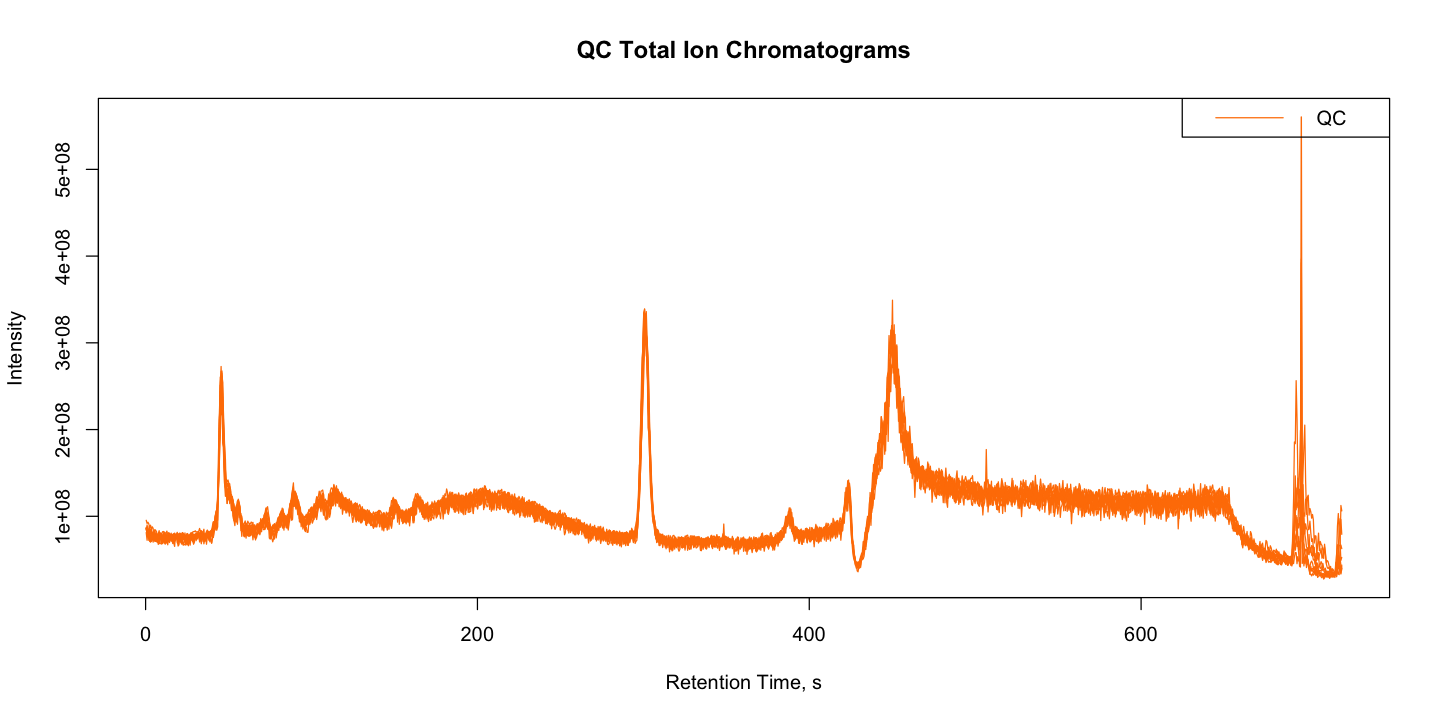

In [15]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

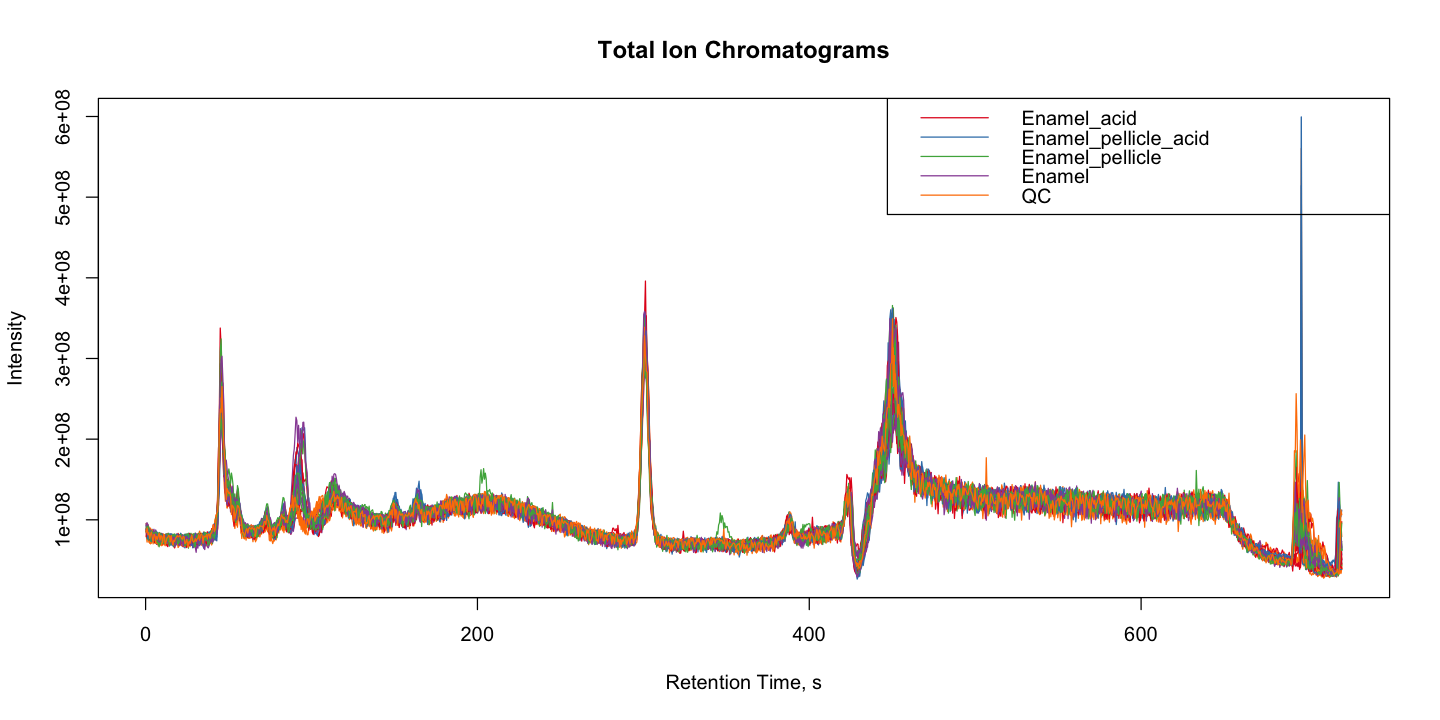

In [16]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

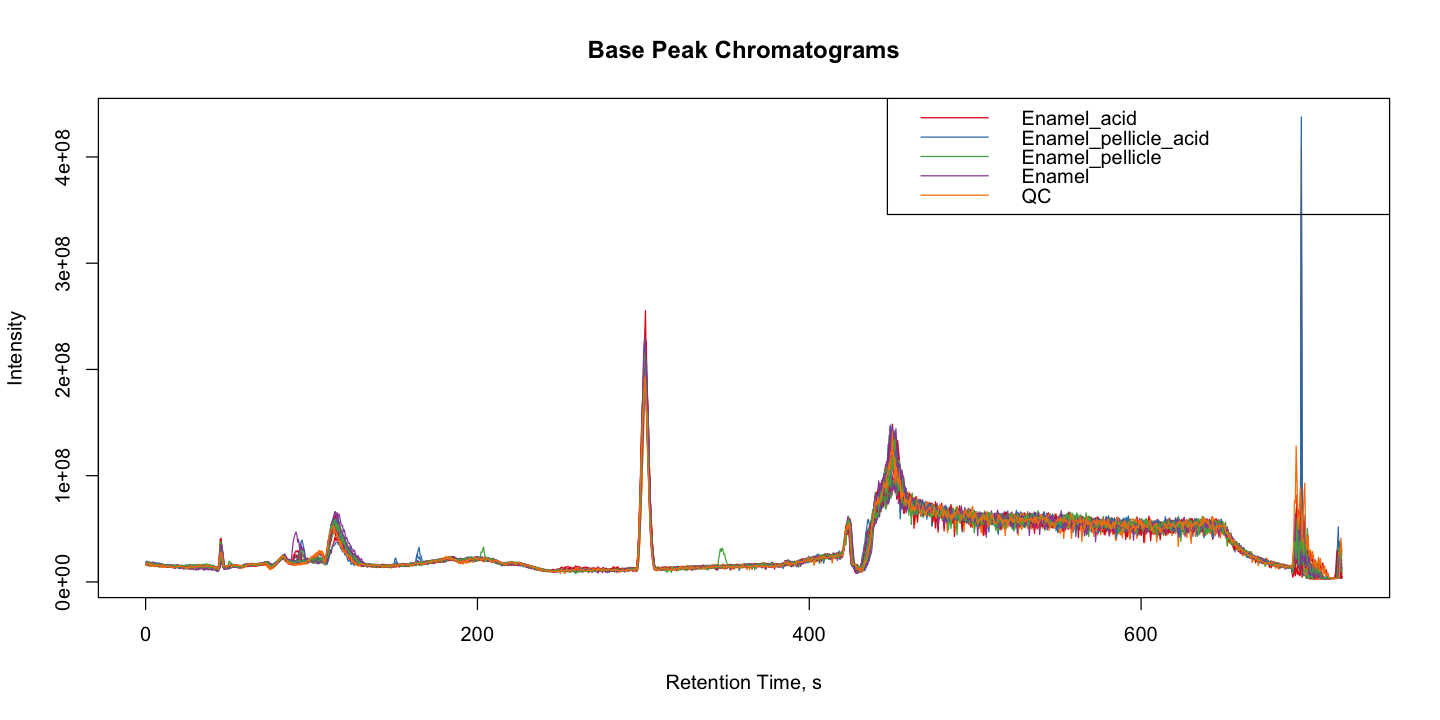

In [17]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

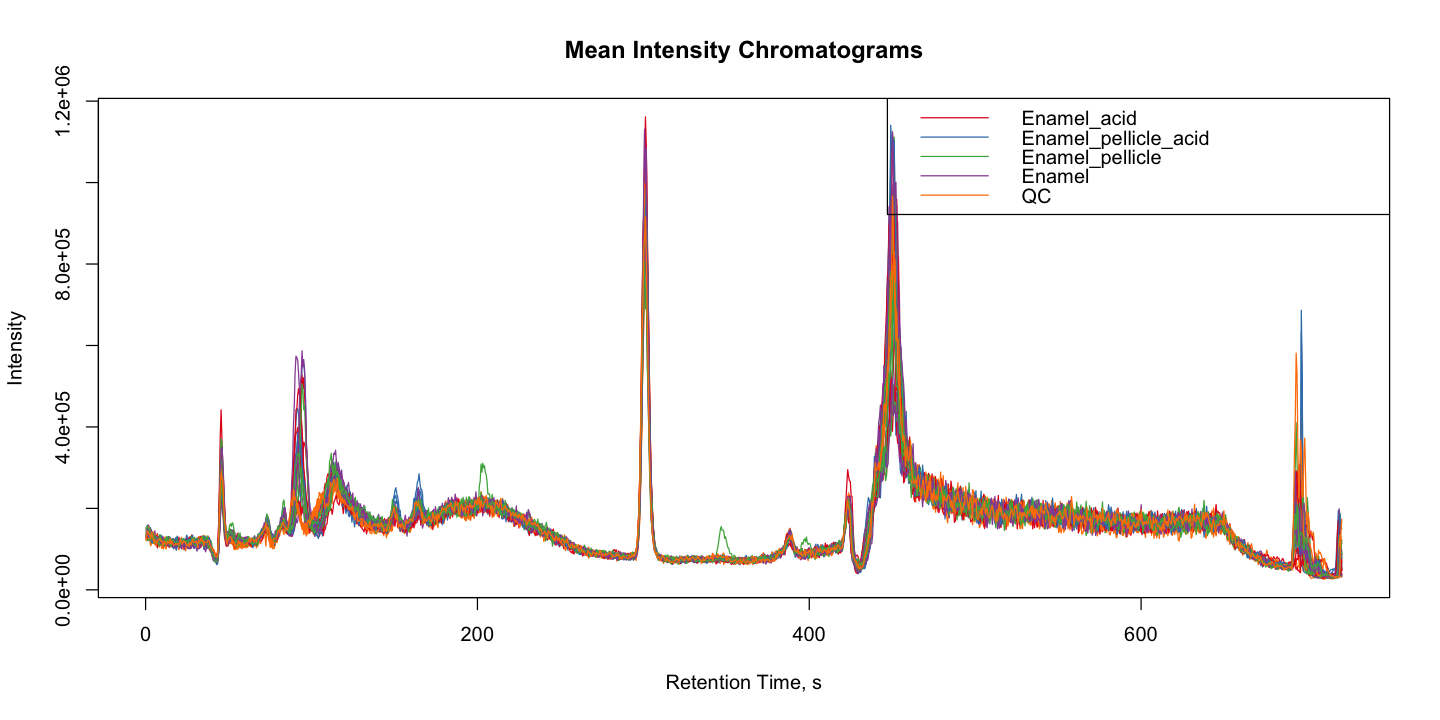

In [18]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

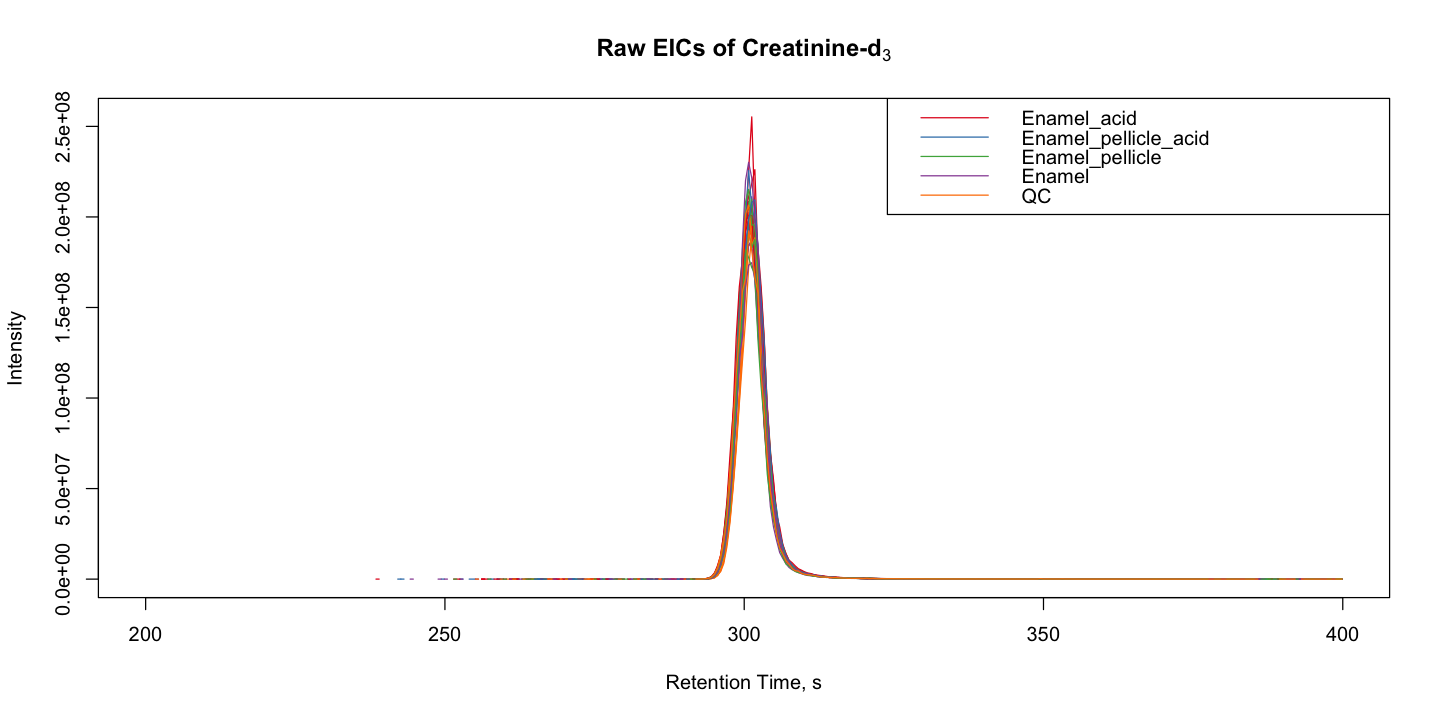

In [19]:
## Plot creatinine-d3 before processing
cread3.raw <- chromatogram(raw, mz = c(117.0845, 117.0856), rt = c(200, 400)) 

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

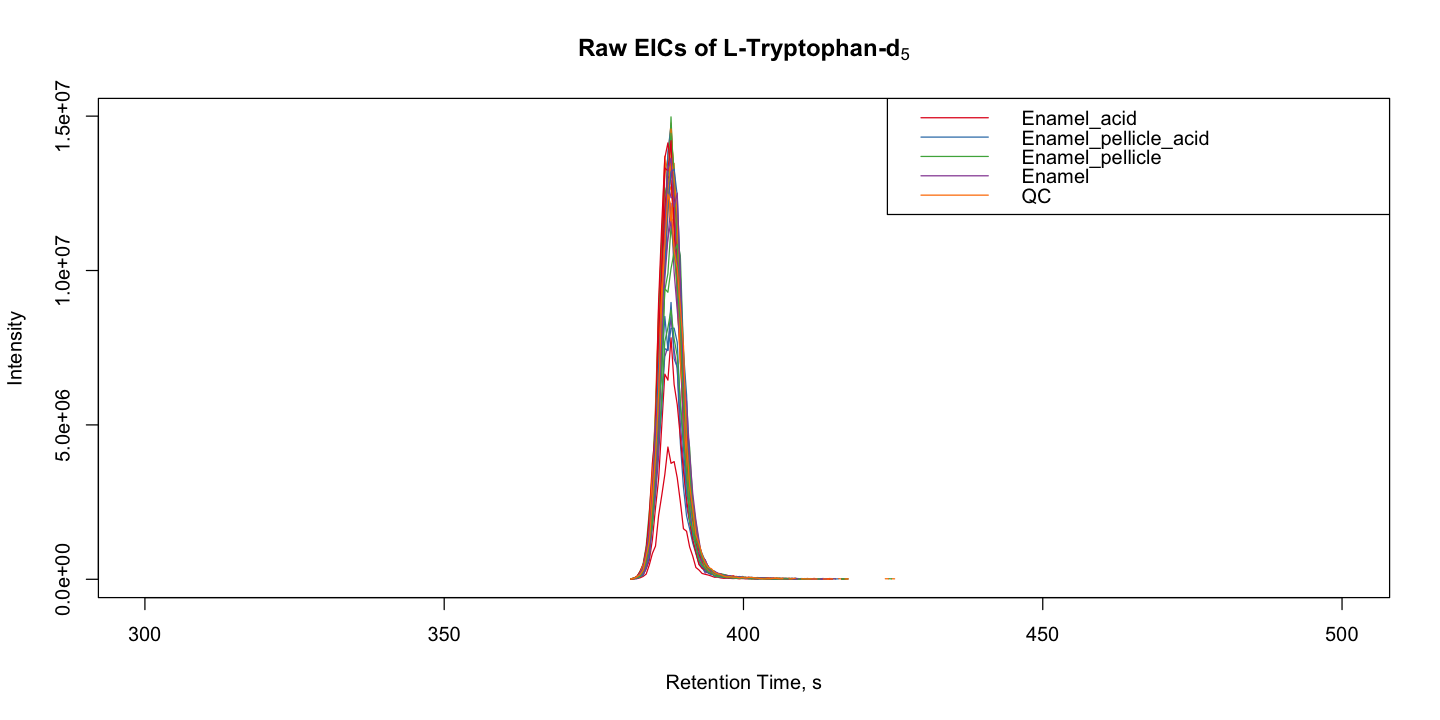

In [20]:
## Plot tryptophan-d5 before processing
trpd5.raw <- chromatogram(raw, mz = c(210.1275, 210.1295), rt = c(300, 500))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of L-Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

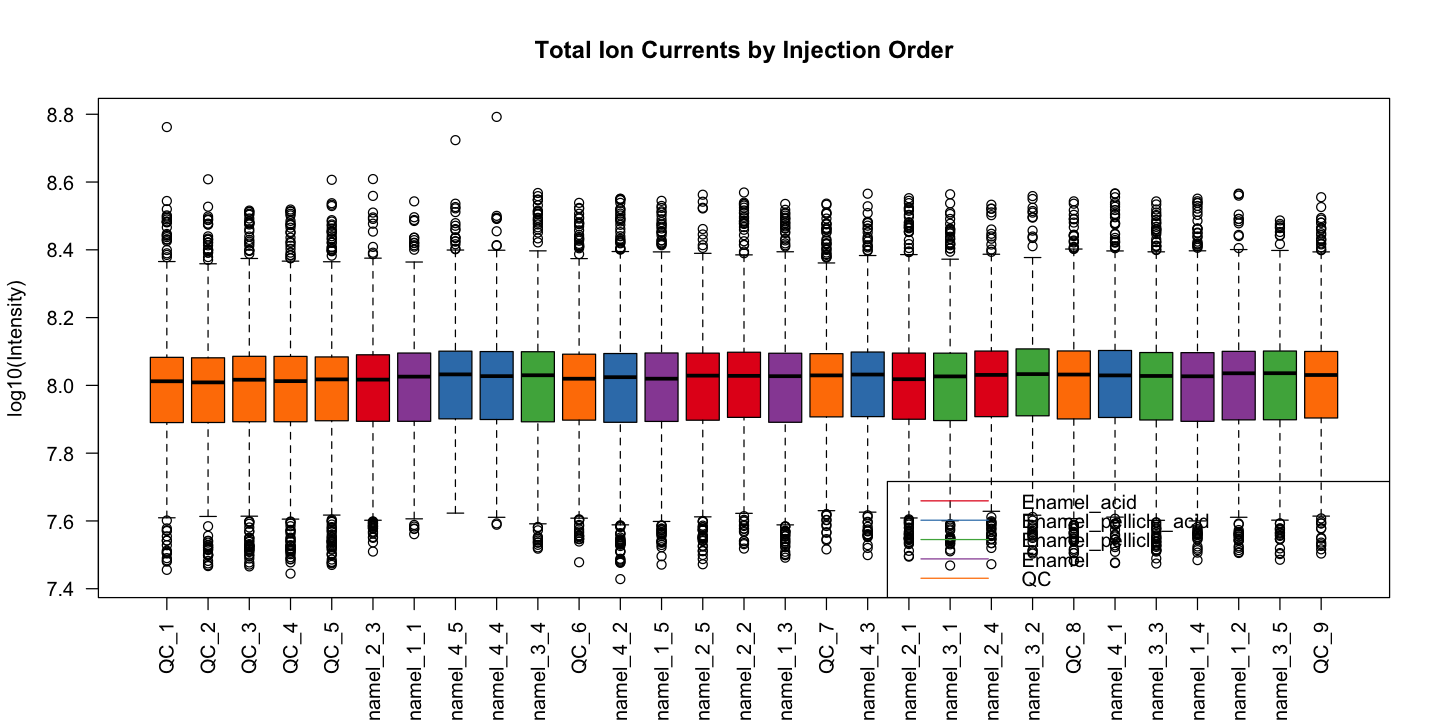

In [21]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

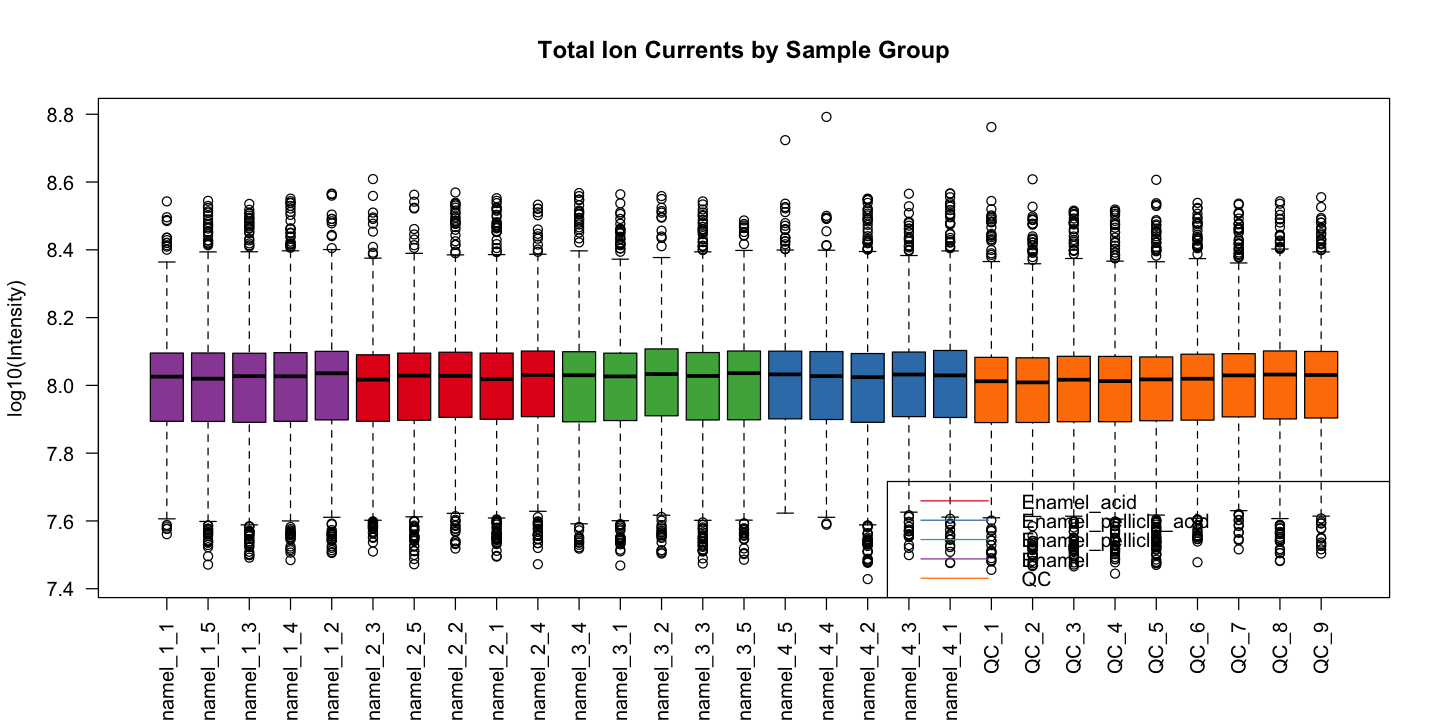

In [22]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [24]:
cwp <- CentWaveParam(peakwidth = c(8.9, 42), ppm = 2.5, snthresh = 35, 
                     mzdiff = 0.022,  prefilter = c(5, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [25]:
## Define sample colours
sample.colours <- paste0(brewer.pal(5, "Set1")[1:5])
names(sample.colours) <- c("Enamel_acid","Enamel_pellicle_acid","Enamel_pellicle","Enamel", "QC")
sample.colours <- sample.colours[raw$sample_group]

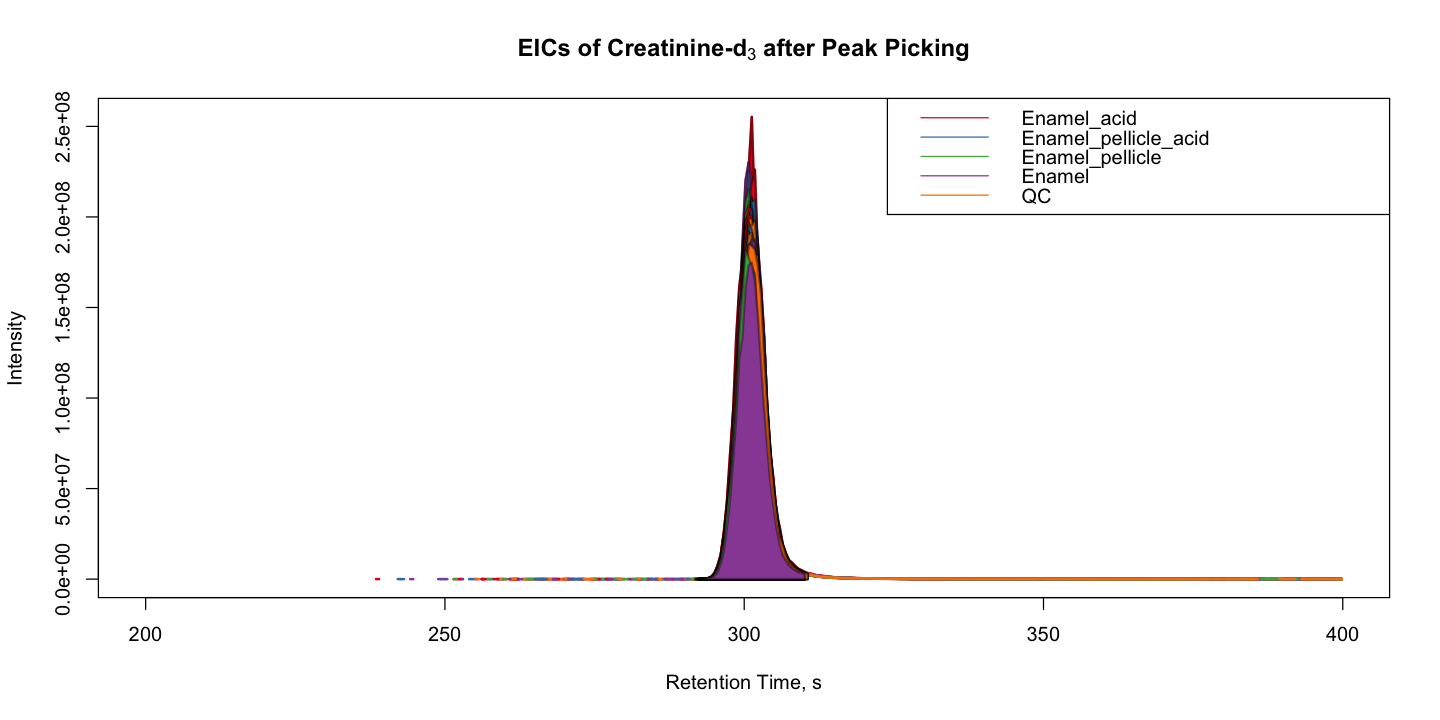

In [26]:
## Plot creatinine-d3 after peak picking
cread3.picked <- chromatogram(set, mz = c(117.0845, 117.0856), rt = c(200, 400)) 

plot(cread3.picked, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.picked)[, "sample"]],
     main = bquote(bold("EICs of Creatinine-d"[3]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

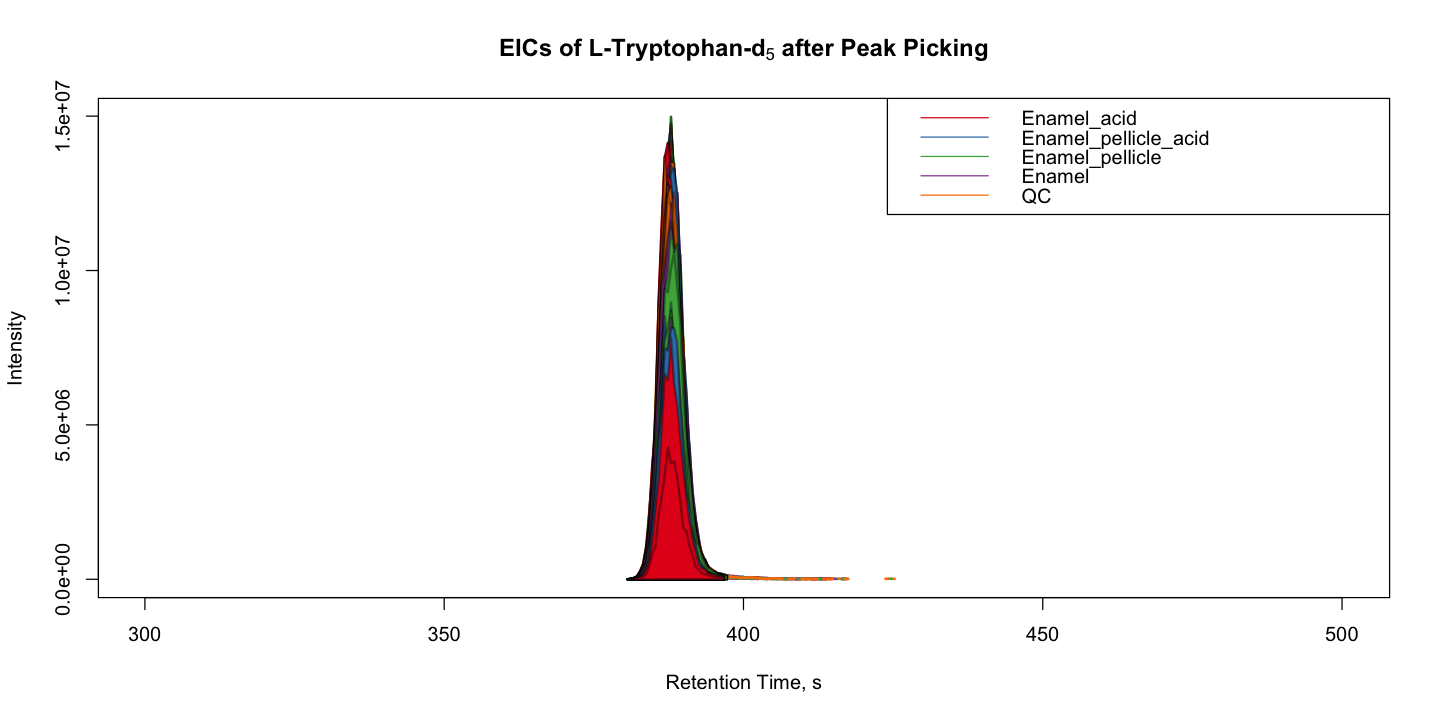

In [27]:
## Plot Tryptophan-d5 after peak picking
trpd5.picked <- chromatogram(set, mz = c(210.1275, 210.1295), rt = c(300, 500)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of L-Tryptophan-d"[5]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Retention Time Correction (RT)

In [28]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.2))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.2)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

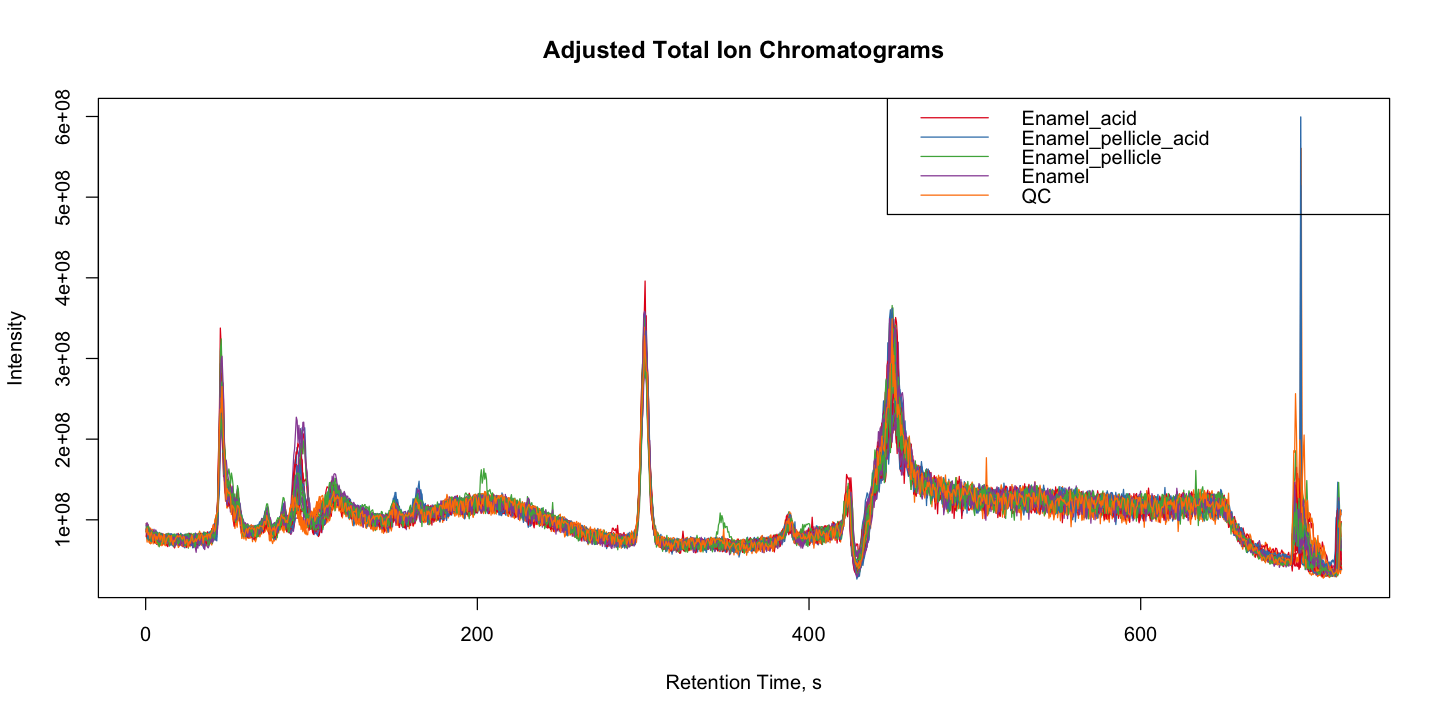

In [29]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

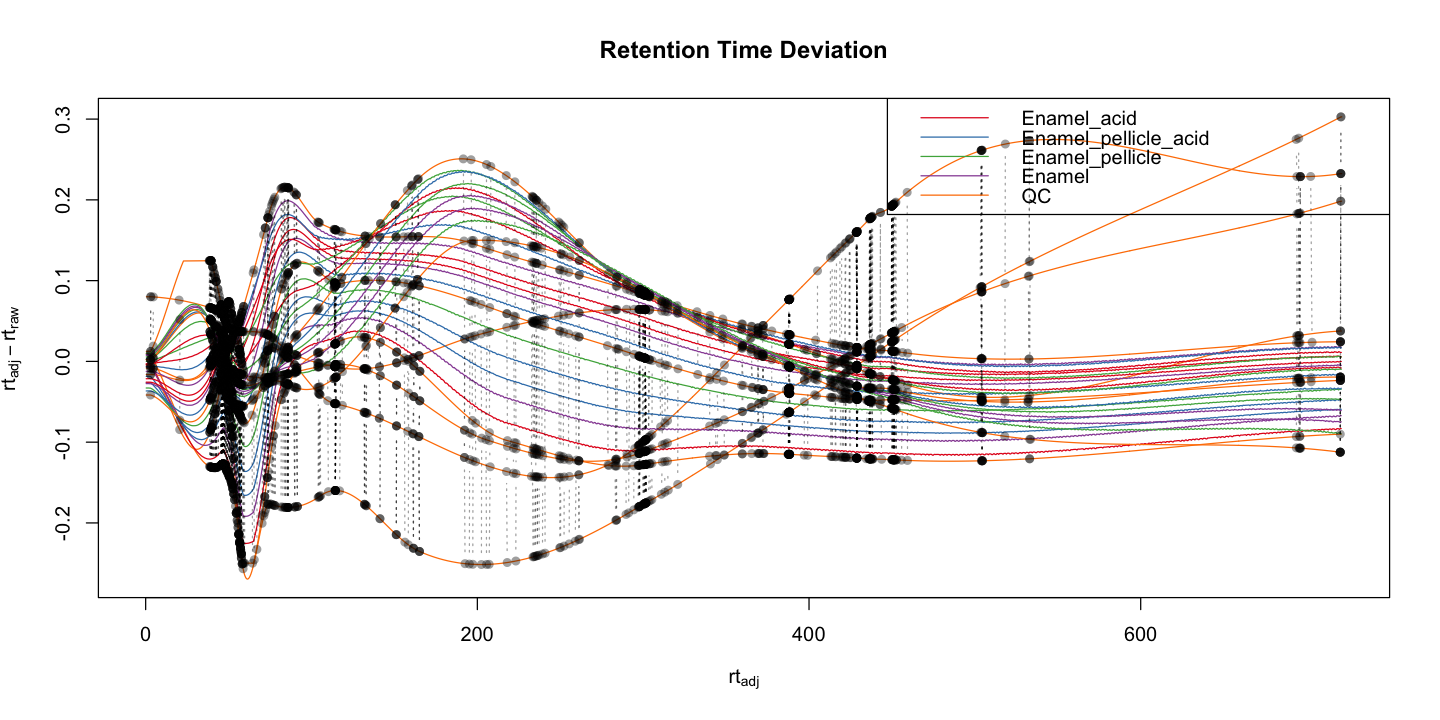

In [30]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

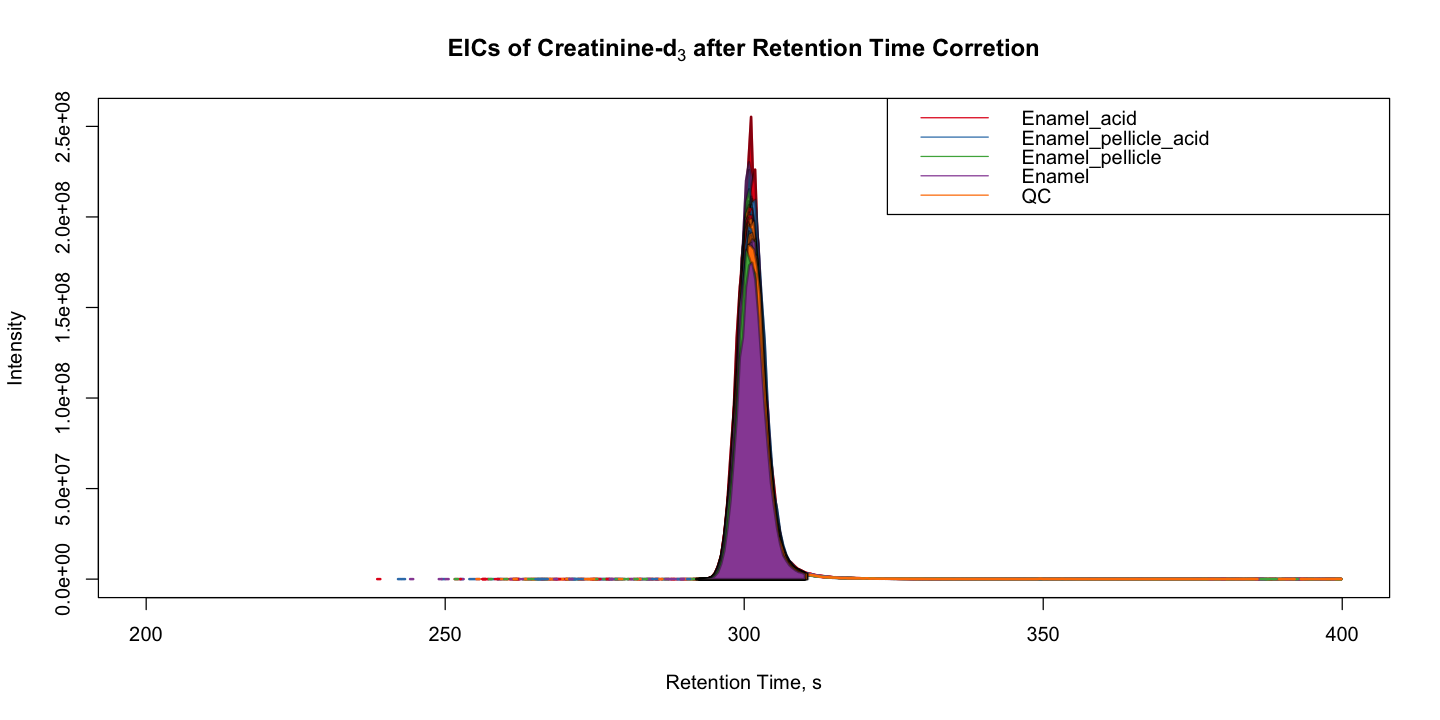

In [31]:
## Plot creatinine-d3 after retention time correction
cread3.corr <- chromatogram(set, mz = c(117.0845, 117.0856), rt = c(200, 400)) 

plot(cread3.corr, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.corr)[, "sample"]],
     main = bquote(bold("EICs of Creatinine-d"[3]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

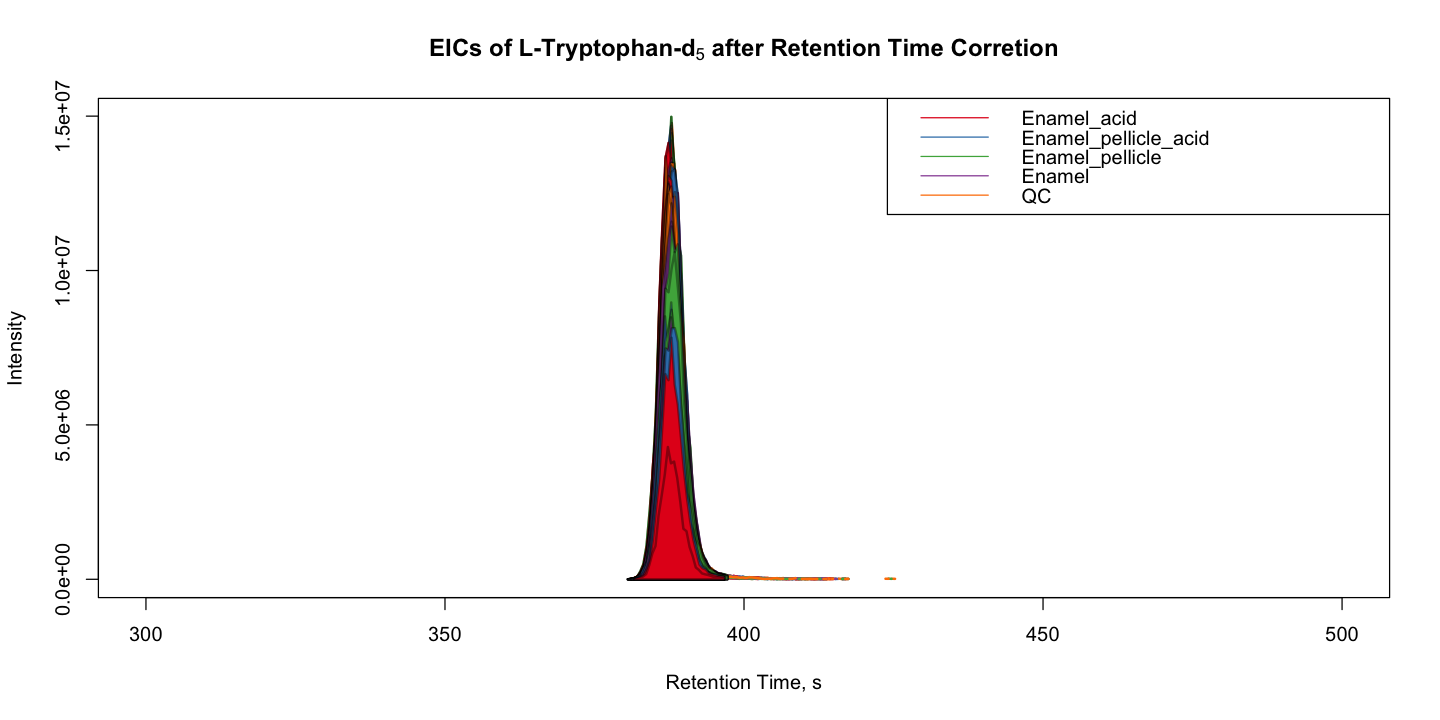

In [32]:
## Plot tryptophan-d5 after retention time correction
trpd5.corr <- chromatogram(set, mz = c(210.1275, 210.1295), rt = c(300, 500)) 

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     main = bquote(bold("EICs of L-Tryptophan-d"[5]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [33]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

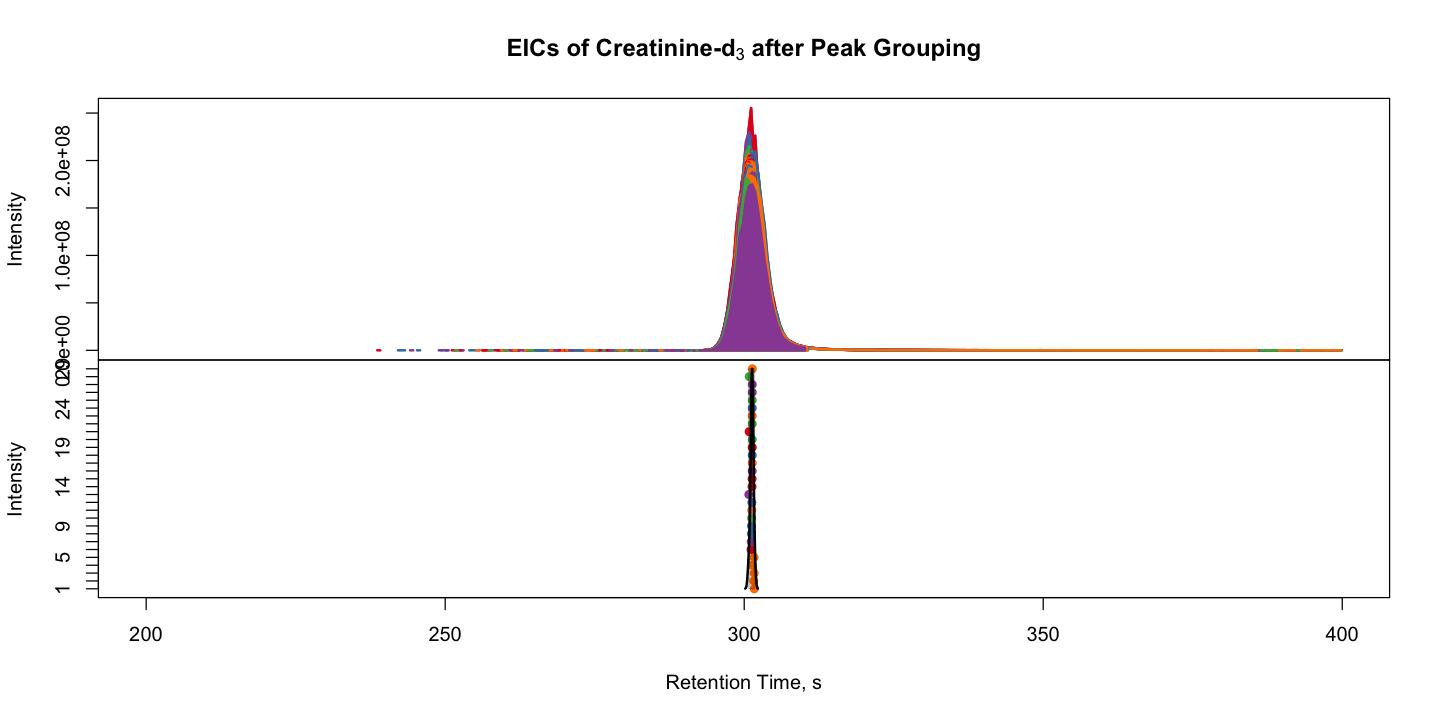

In [34]:
## Plot creatinine-d3 after peak grouping
cread3.grouped <- chromatogram(set, mz = c(117.0851, 117.0861), rt = c(200, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(cread3.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Creatinine-d"[3]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

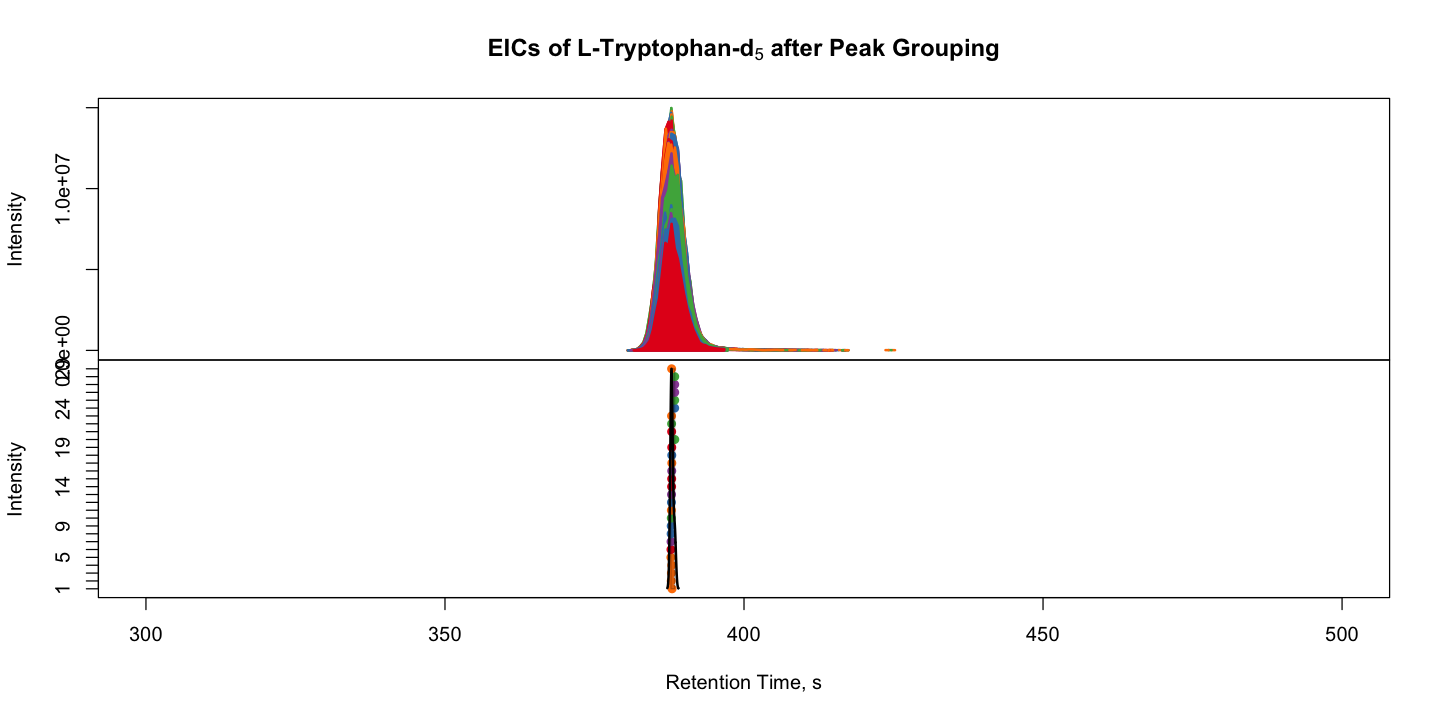

In [35]:
## Plot tryptophan-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1275, 210.1295), rt = c(300, 500))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of L-Tryptophan-d"[5]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

### Peak Filling

In [36]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [37]:
## Summarise experiment
results <- quantify(set, value = "into")

In [38]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [39]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 88 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  30  40  50  60  70  80  90  100  
Found isotopes: 172 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 88 Groups... 
 % finished: 10  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 88 Groups... 
 % finished: 10  30  40  50  60  70  80  90  100  
New number of ps-groups:  382 
xsAnnotate has now 382 groups, instead of 88 
Generating peak matrix for peak annotation!

Calculating possible adducts in 382 Groups... 
 % finished: 10  30  40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [40]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [41]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

# Normalisation

In [42]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Batch correction

In [43]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [44]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$analysis_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

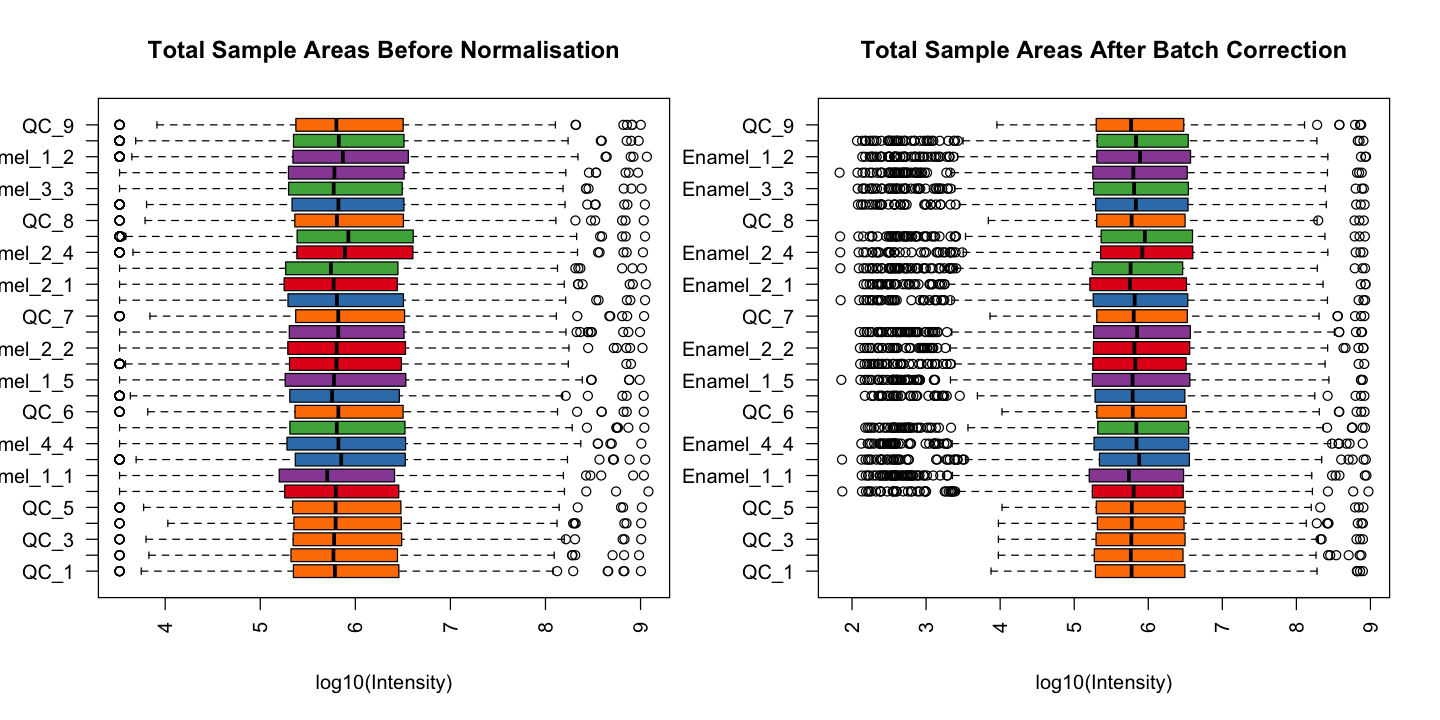

In [45]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

### Filter Results

In [46]:
results.filtered <- results

## Statistical Evaluation

In [78]:
## Define results column
rowData(results)$pvalue <- NA

## Calculate ANOVA for each feature
anova.table <- results[,results$sample_group != "QC"] %>%
               assay("batchcorr") %>%
               t()
anova.factor <- results$sample_group[results$sample_group != "QC"]

for(i in 1:ncol(anova.table)) {
        
    sum <- aov(anova.table[,i]~anova.factor) %>%
           summary() %>%
           unlist()
    rowData(results)$pvalue[i] <- sum["Pr(>F)1"]
    
    }

## Evaluate p-values
rowData(results)$significant <- ifelse(rowData(results)$pvalue < 0.005,
                                       TRUE, FALSE)

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


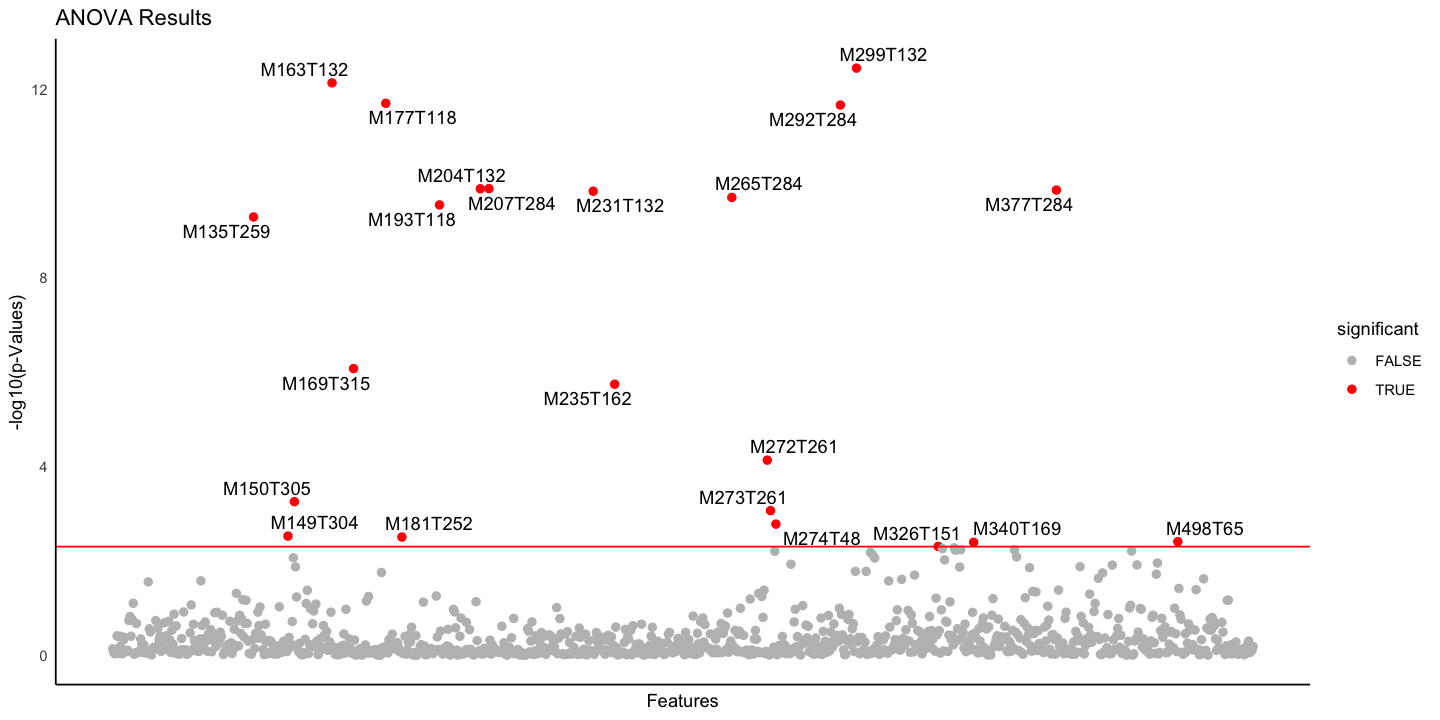

In [79]:
coloursBoolean <- c("TRUE" = "red", "FALSE" = "grey")

results %>%
rowData() %>%
as.data.frame %>%
ggplot(aes(x = 1:nrow(rowData(results)), y = -log10(pvalue),
           label = ifelse(rowData(results)$significant, 
                          rowData(results)$label, ""), colour = significant)) +
geom_point(size = 2) +
scale_color_manual(values = coloursBoolean) +
geom_hline(yintercept = -log10(0.005), colour = "red") +
geom_text_repel(point.padding = 0.2, colour = "black") +
ggtitle("ANOVA Results") +
xlab("Features") +
ylab("-log10(p-Values)") +
theme_classic() +
theme(axis.text.x = element_blank(),
      axis.ticks = element_blank())

### Evaluate Significance

In [80]:
results.filtered <- results[rowData(results)$significant == TRUE,]

### Hierarchical Clustering

In [81]:
## Calculate row and column cluster
r.cluster <- results.filtered %>%
             assay("batchcorr") %>%
             dist(method = "manhattan") %>%
             hclust(method = "complete") %>%
             as.dendrogram()

c.cluster <- results.filtered %>%
             assay("batchcorr") %>%
             t() %>%
             dist(method = "manhattan") %>%
             hclust(method = "complete") %>%
             as.dendrogram()

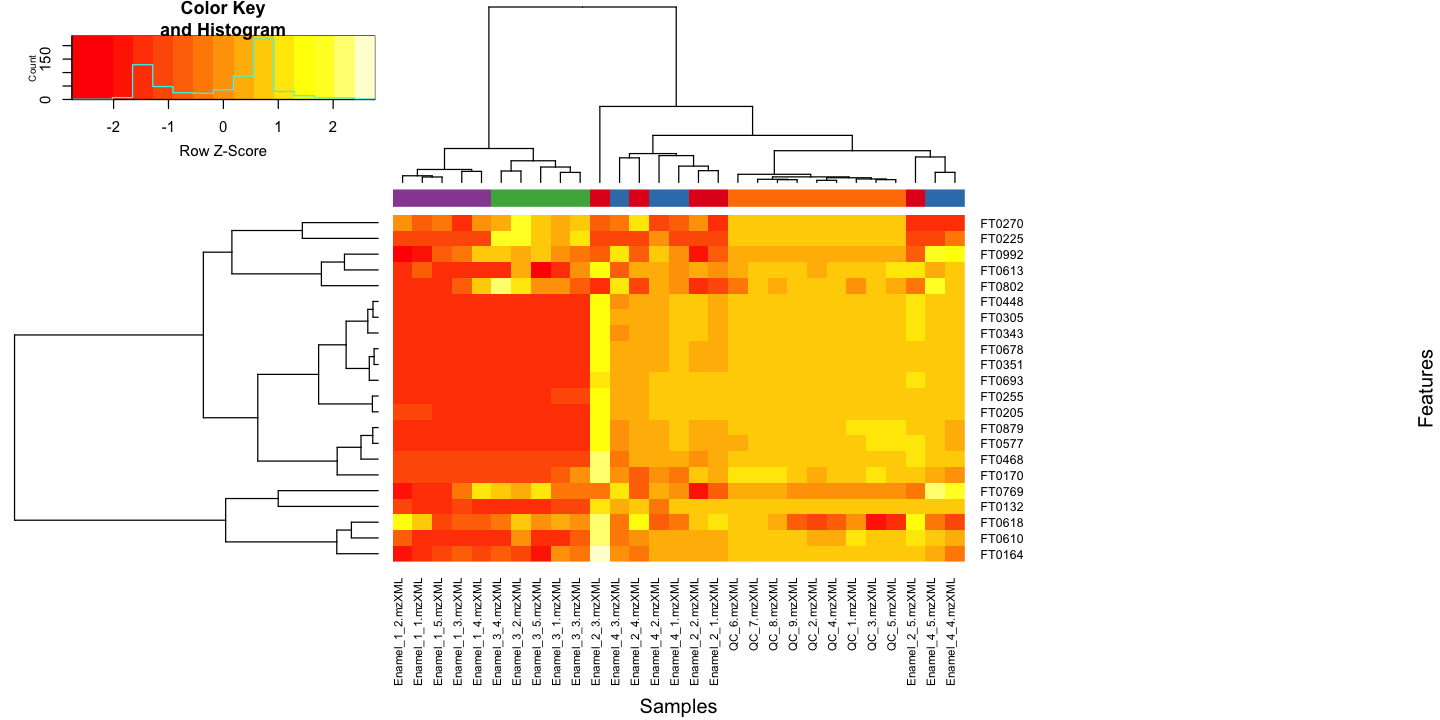

In [82]:
## Plot results of hierarchical clustering
results.filtered %>%
assay("batchcorr") %>%
heatmap.2(scale = "row", margins = c(10,30), trace = "none", 
          Rowv = r.cluster, Colv = c.cluster, ColSideColors = group.colours[results$sample_group],
         xlab = "Samples", ylab = "Features")

### t-SNE

In [83]:
## Perform t-SNE
tsne <- results.filtered %>%
        assay("batchcorr") %>%
        t() %>%
        Rtsne(dim = 2, perplexity = 4, 
              epoch = 100,verbose = FALSE, 
              pca_center = TRUE, pca_scale = FALSE)

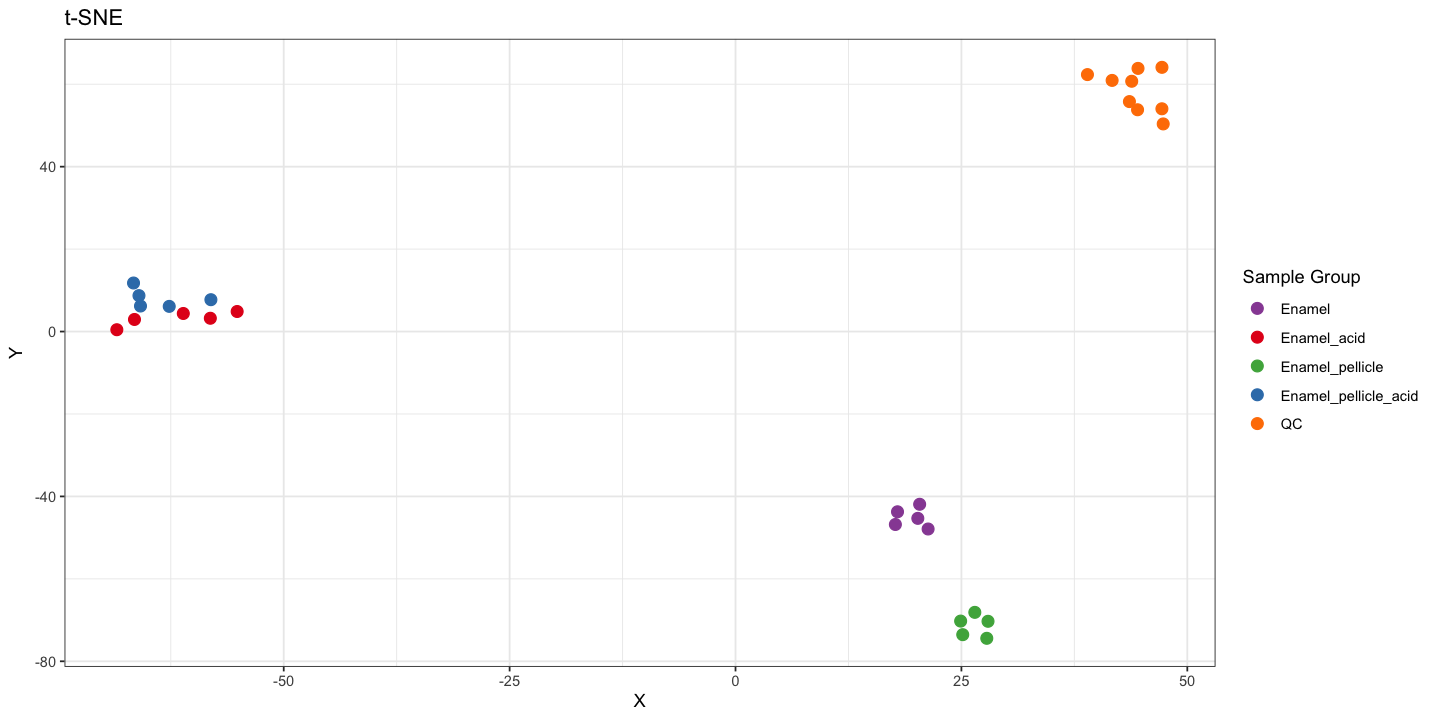

In [84]:
tsne$Y %>%
as.data.frame() %>%
ggplot(aes(x = V1, y = V2, col = results.filtered$sample_group)) +
geom_point(size = 3) +
labs(fill="Sample Group") +
scale_color_manual("Sample Group", values = group.colours) +
#geom_text(aes(label = rownames(pca$x)), vjust = -0.5, hjust = 0.5) +
ggtitle("t-SNE") +
xlab("X") +
ylab("Y") +
theme_bw()

### Principal Component Analysis

In [85]:
## Perform PCA of significant features
pca <- results.filtered %>%
       assay("batchcorr") %>%
       t() %>%
       prcomp(center = TRUE)

## Perform summary of PCA characteristics
pca.summary <- summary(pca)
var <- results.filtered %>%
       assay("batchcorr") %>%
       var()
eig <- pca$sdev^2
kaiser <- length(which(eig > mean(eig)))
jolliffe <- length(which(eig > (0.7*mean(eig))))
scree <- data.frame(PC = seq(from = 1, to = length(eig), by = 1),
                    Eigenvalue = eig/sum(eig))
scree$Importance <- pca.summary$importance[3,]
scree <- reshape(data = scree, direction = "long",
                     varying = c("Eigenvalue", "Importance"),
                     v.names = "Value", idvar = "PC",
                     timevar = "Characteristic",
                     times = c("Eigenvalue", "Importance"))

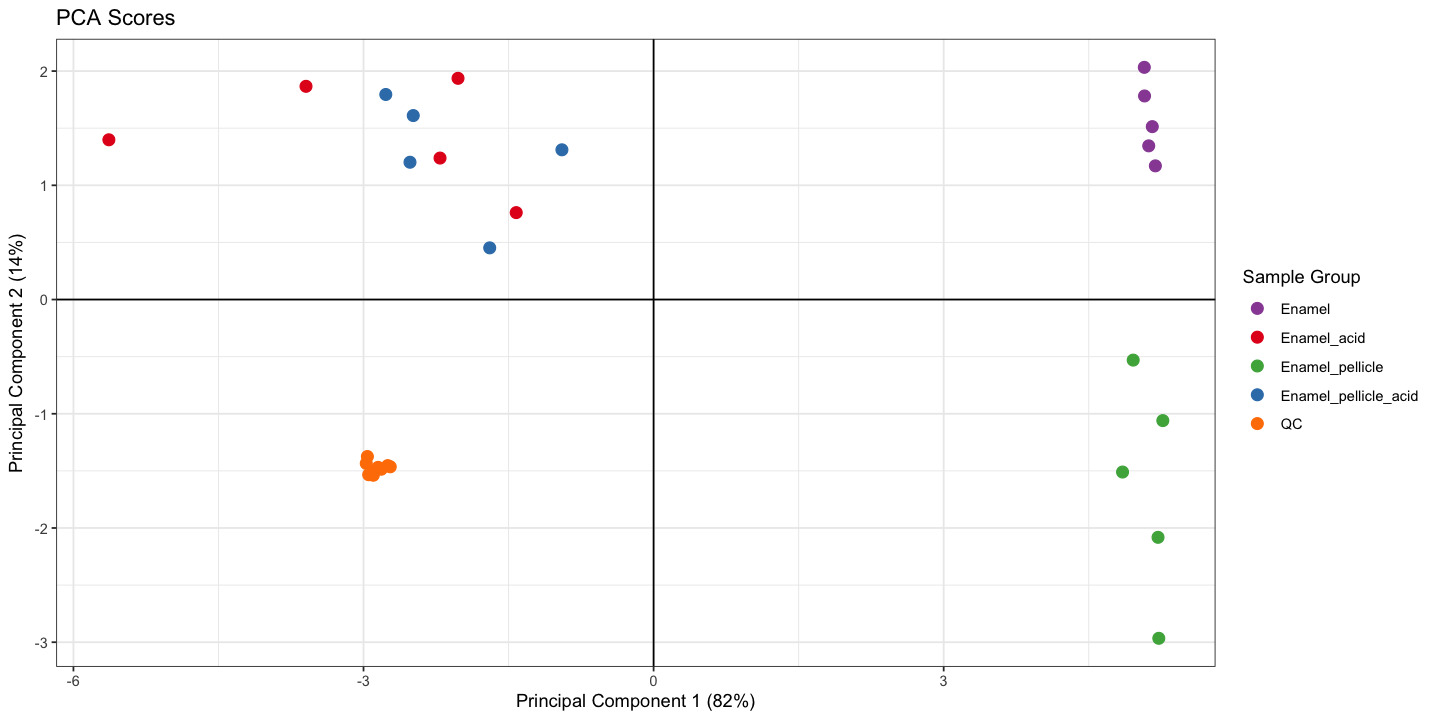

In [86]:
## Plot PCA scores
pca$x %>%
as.data.frame %>%
ggplot(aes(x = PC1, y = PC2)) +
geom_point(size = 3, aes(col = results.filtered$sample_group)) +          
scale_color_manual("Sample Group", values = group.colours) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle("PCA Scores") +
#geom_text(aes(label = rownames(pca$x)), vjust = -0.5, hjust = 0.5) +
xlab(paste0("Principal Component 1", " ", "(", 
            round(pca.summary$importance[2,1]*100, 0), "%)")) +
ylab(paste0("Principal Component 2", " ", "(", 
            round(pca.summary$importance[2,2]*100, 0), "%)")) +
theme_bw() 

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


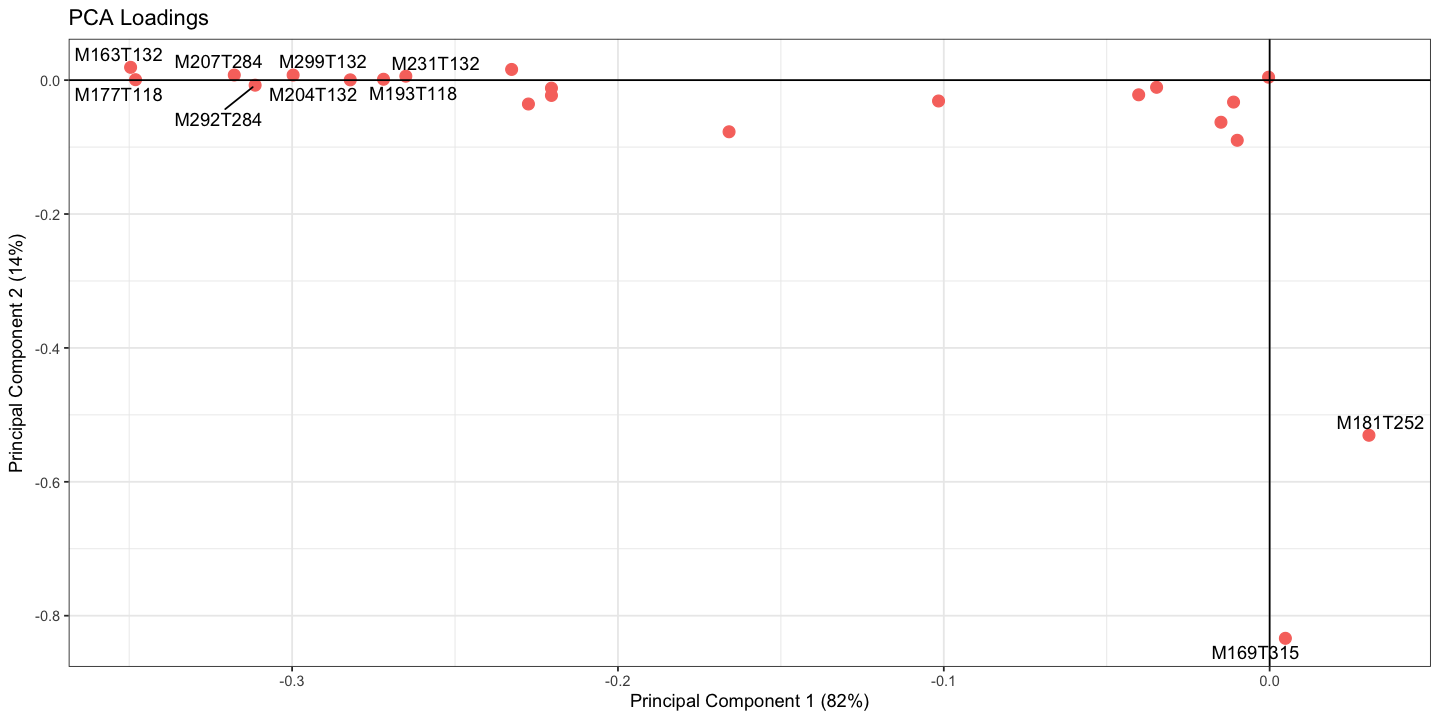

In [87]:
## Plot PCA loadings
pca$rotation %>%
data.frame(label = rowData(results.filtered)$label, 
           abs_loading = sqrt((pca$rotation[,1])^2 + (pca$rotation[,2])^2)) %>%
ggplot(aes(x = PC1, y = PC2,
           label = ifelse(abs_loading >= sort(abs_loading, 
                                              decreasing = TRUE)[10], label, ""))) +
geom_point(size = 3, show.legend = FALSE, aes(col = "red")) +
geom_text_repel(point.padding = 0.2) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle("PCA Loadings") +
xlab(paste0("Principal Component 1", " ", "(", 
            round(pca.summary$importance[2,1]*100, 0), "%)")) +
ylab(paste0("Principal Component 2", " ", "(", 
            round(pca.summary$importance[2,2]*100, 0), "%)")) +
theme_bw()

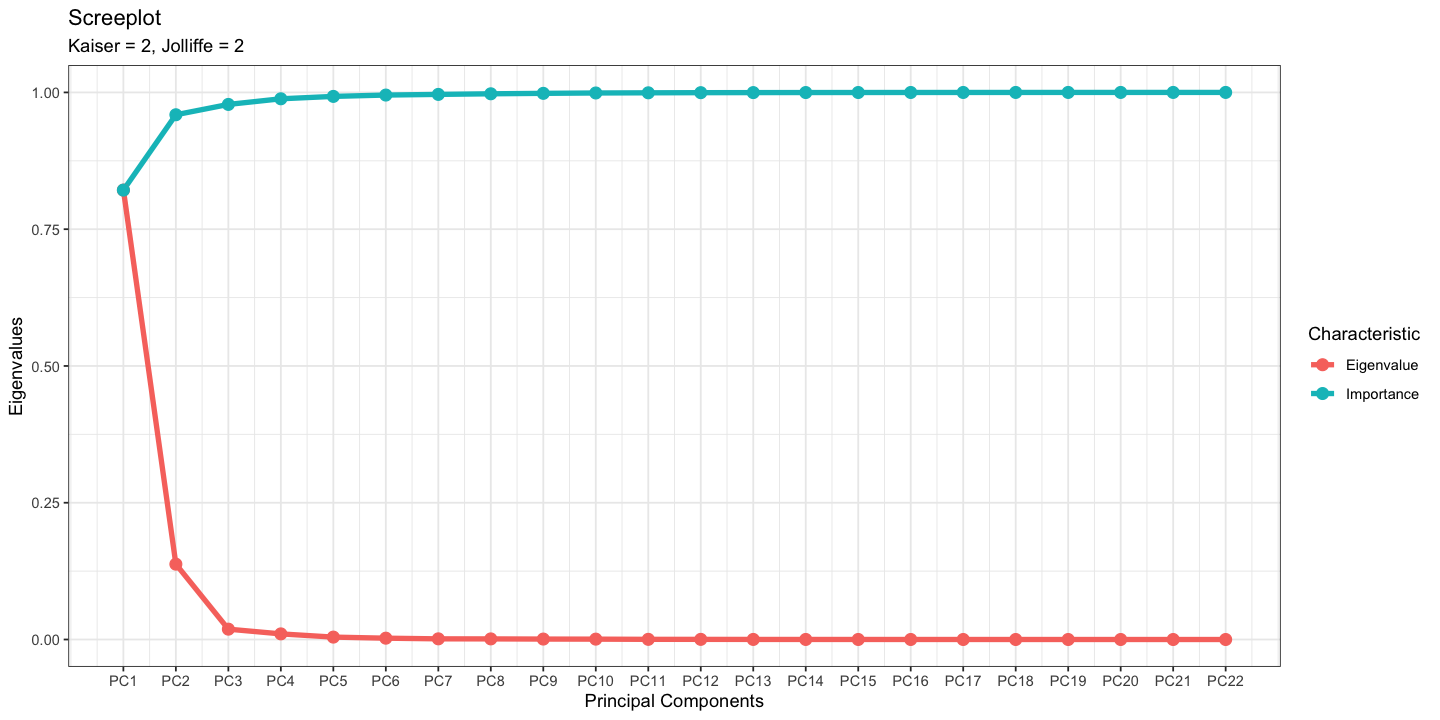

In [88]:
scree %>%
ggplot(aes(x = PC, y = Value, group = Characteristic,
                                     colour = Characteristic)) +        
geom_line(size = 1.5) +
geom_point(size = 3) +
scale_x_continuous(breaks = unique(scree$PC), labels = colnames(pca$rotation)) +
ggtitle(label = "Screeplot",
        subtitle = paste0("Kaiser = ", kaiser, ", Jolliffe = ", jolliffe)) +
xlab("Principal Components") +
ylab("Eigenvalues") +
theme_bw()

### PC-LDA

In [89]:
## Determine number of PCs for LDA
n.pc <- length(which(pca$sdev^2 > mean(pca$sdev^2)))
n.pc <- ifelse(n.pc < 3, 3, n.pc)

## Perform LDA and calculate new loadings
pc.ldam <- pca$x[,1:n.pc] %>%
           as.matrix() %>%
           lda(results$sample_group)

pc.lda.loadings <- pca$rotation[,1:n.pc] %*% pc.ldam$scaling

# Calculate aboslute loading and save to results
rowData(results.filtered)$abs_loading <- sqrt(abs(pc.lda.loadings[,1])^2 + 
                                     abs(pc.lda.loadings[,2])^2)

## Calculate prediction accuracy and cohens kappa
monte.carlo <- train(pca$x[,1:n.pc], results.filtered$sample_group,
                     method = "lda",
                     trControl = trainControl(method = "LGOCV"))
cvaccuracy <- as.numeric(round(monte.carlo$results[2]*100, 0))
cvkappa <- as.numeric(round(monte.carlo$results[3]*100, 0))
    
## Predict model for test data
p <- predict(pc.ldam, as.data.frame(pca$x[,1:n.pc]))

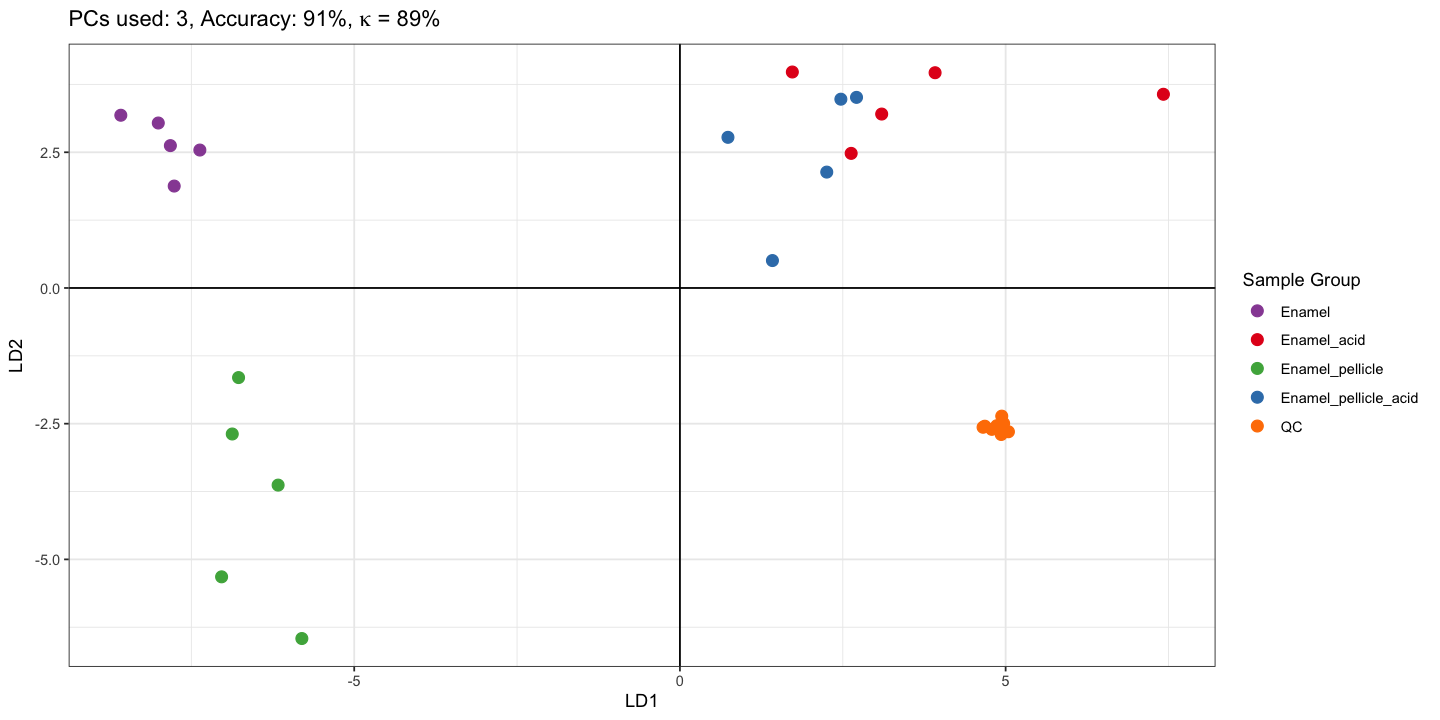

In [90]:
## Plot PC-LDA scores
p$x %>%
as.data.frame() %>%
ggplot(aes(x = LD1, y = LD2)) +
geom_point(size = 3, aes(col = results.filtered$sample_group)) +
scale_color_manual("Sample Group", values = group.colours) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle(substitute(paste("PCs used: ", n_pc, ", ", "Accuracy: ", 
                         cvacc, "%, ", kappa, " = ", cvka, "%"),
                   list(n_pc = n.pc, cvacc = cvaccuracy, cvka = cvkappa))) +
theme_bw()

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


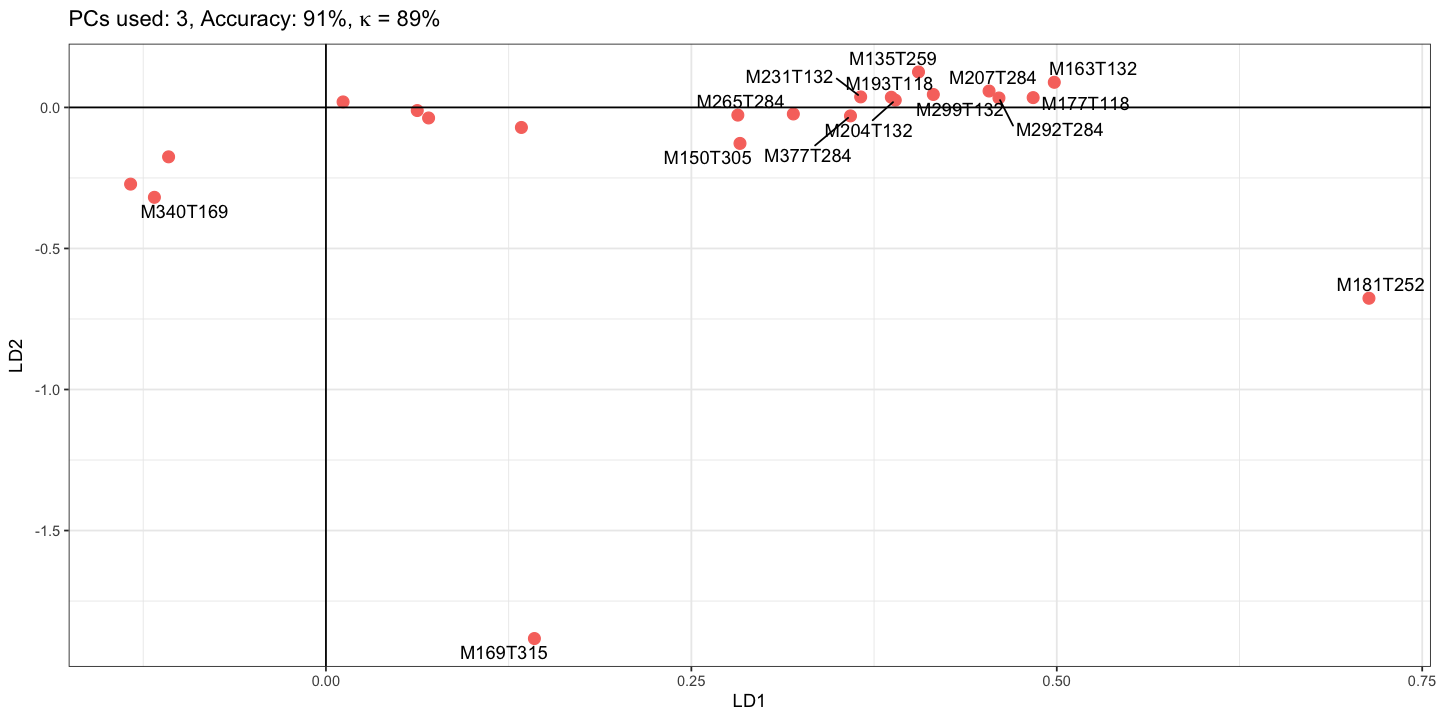

In [91]:
## Plot PCA loadings
pc.lda.loadings %>%
data.frame(label = rowData(results.filtered)$label, 
           abs_loading = rowData(results.filtered)$abs_loading) %>%
ggplot(aes(x = LD1, y = LD2, label = ifelse(abs_loading >= sort(abs_loading, 
                                              decreasing = TRUE)[15], label, ""))) +
geom_point(size = 3, aes(col = "red"), show.legend = FALSE) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
geom_text_repel(point.padding = 0.2) +
ggtitle(substitute(paste("PCs used: ", n_pc, ", ", "Accuracy: ", cvacc, "%, ",
                         kappa, " = ", cvka, "%"),
                   list(n_pc = n.pc, cvacc = cvaccuracy, cvka = cvkappa))) +
theme_bw()

## Summarise significant features to a table

In [94]:
summary <- results.filtered %>%
           rowData() %>%
           as.data.frame() %>%
           filter(significant == TRUE) %>%
           dplyr::select(label, mzmed, rtmed, pvalue, abs_loading,
                         isotopes, adduct, pcgroup) %>%
           arrange(desc(abs_loading))
summary[1:24,]

label    mzmed    rtmed     pvalue       abs_loading isotopes  
FT0225 M169T315 169.0698 314.81310 8.433225e-07 1.88817501            
FT0270 M181T252 181.0698 252.11982 3.134542e-03 0.98326605            
FT0205 M163T132 163.0343 132.24770 7.447961e-13 0.50618256            
FT0255 M177T118 177.0500 118.27062 2.020776e-12 0.48508018            
FT0678 M292T284 292.0018 284.04898 2.195976e-12 0.46164277            
FT0351 M207T284 207.0242 283.69063 1.294092e-10 0.45736938            
FT0132 M135T259 135.0031 259.32276 5.172052e-10 0.42438153            
FT0693 M299T132 299.0093 132.13324 3.631212e-13 0.41806241            
FT0343 M204T132 204.0609 132.24321 1.306397e-10 0.39034834            
FT0305 M193T118 193.0240 117.63172 2.872789e-10 0.38847738            
FT0448 M231T132 231.0218 132.24321 1.473257e-10 0.36772730            
FT0879 M377T284 376.9796 284.01372 1.392418e-10 0.36011678            
FT0802 M340T169 340.3577 169.14256 4.050091e-03 0.33961668            
FT0577 M265T284 264.9828 283.50083 1.994126e-10 0.32060434            
FT0170 M150T305 150.1148 304.96863 5.572510e-04 0.31066676  [10][M+1]+
FT0992 M498T65  498.4009  65.25906 3.917444e-03 0.30299447            
FT0468 M235T162 235.0555 161.86259 1.810204e-06 0.28311514            
FT0769 M326T151 326.3785 150.96301 4.944569e-03 0.20561245  [97][M]+  
FT0164 M149T304 149.1114 303.94231 2.984497e-03 0.15141881  [10][M]+  
FT0613 M273T261 273.2619 261.30672 8.635275e-04 0.07955110  [74][M+1]+
FT0610 M272T261 272.2586 261.35883 7.352015e-05 0.06344650  [74][M]+  
FT0618 M274T48  274.1650  48.11152 1.667290e-03 0.02274494  [77][M]+  
NA     NA             NA        NA           NA         NA  NA        
NA.1   NA             NA        NA           NA         NA  NA        
       adduct         pcgroup
FT0225                43     
FT0270                54     
FT0205                182    
FT0255                48     
FT0678                272    
FT0351                269    
FT0132                213    
FT0693                183    
FT0343                180    
FT0305                98     
FT0448                179    
FT0879                273    
FT0802                77     
FT0577                270    
FT0170                35     
FT0992                60     
FT0468                217    
FT0769                17     
FT0164                35     
FT0613                29     
FT0610                29     
FT0618 [M+K]+ 235.198 8      
NA     NA             NA     
NA.1   NA             NA

In [95]:
write.csv(summary, "Summary.csv")

## Significant Feature Chromatograms

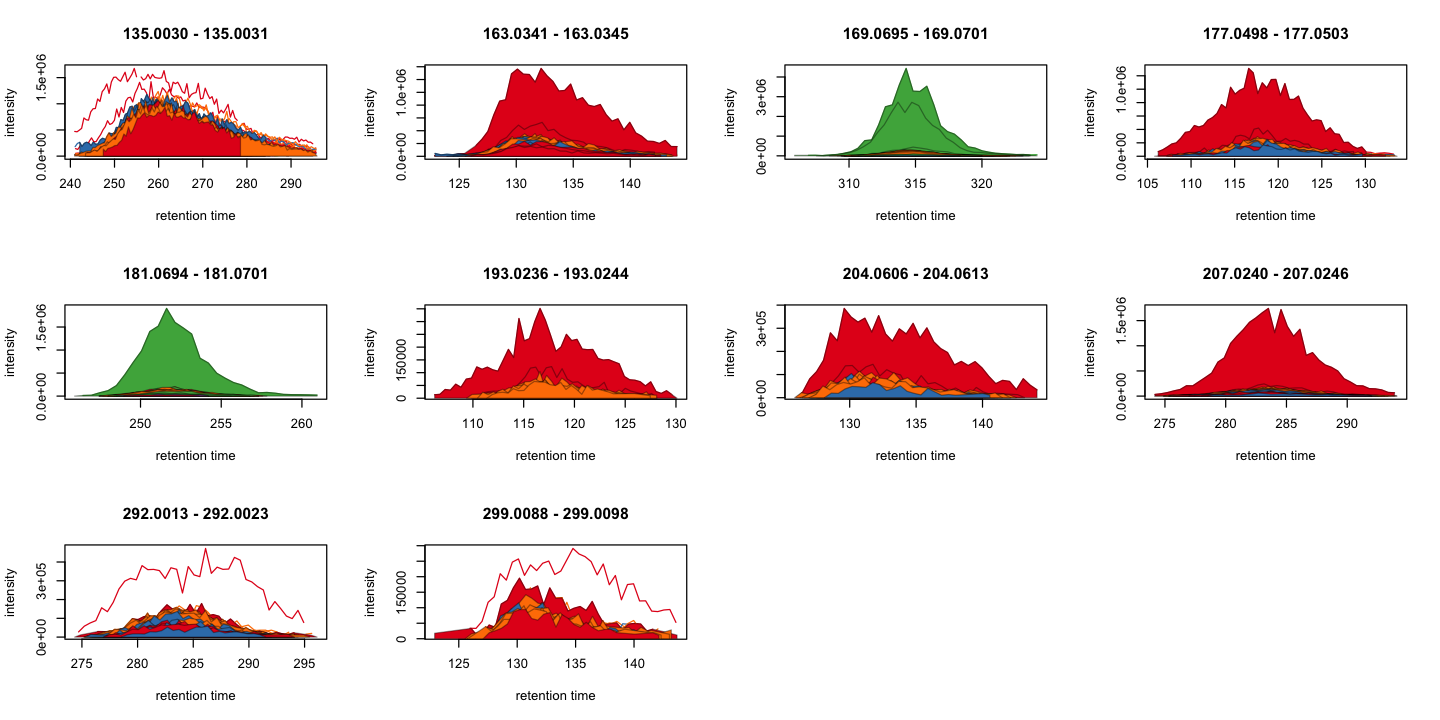

In [96]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[1:10])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

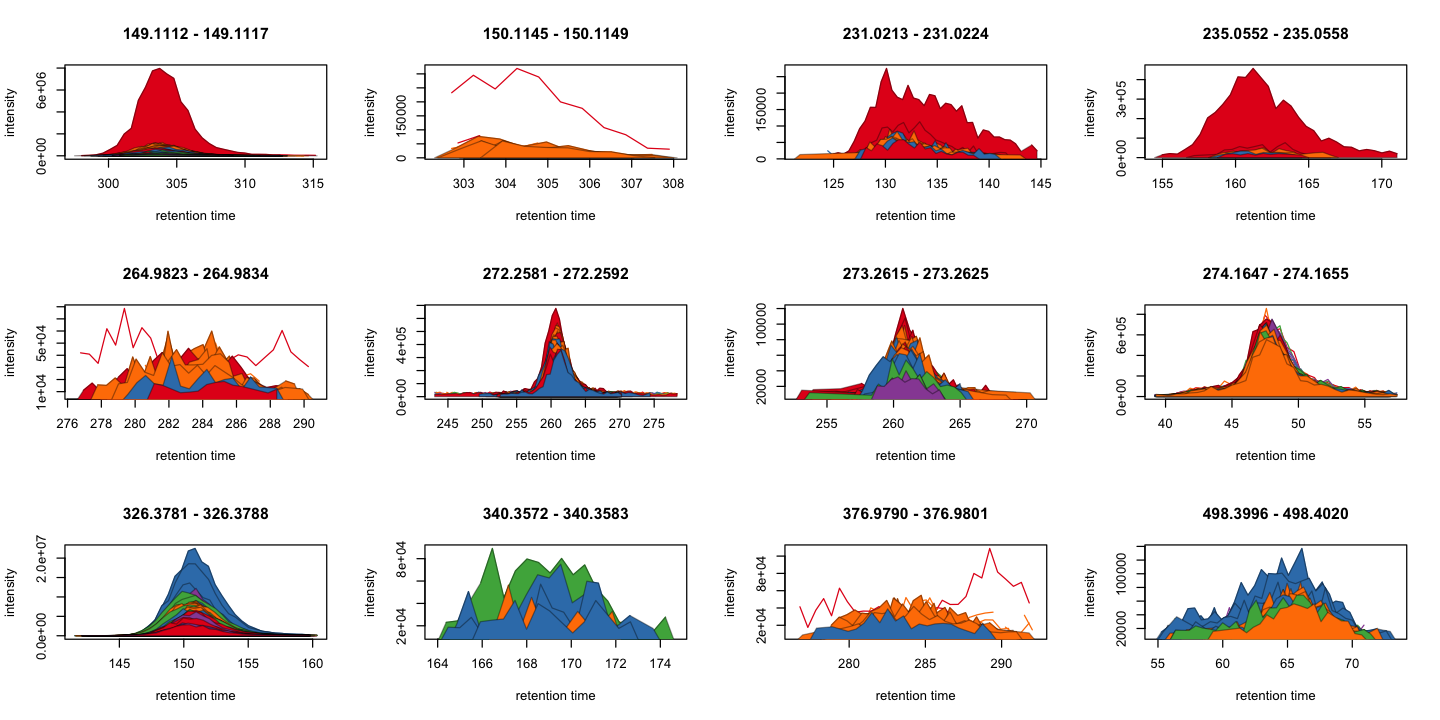

In [97]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[11:22])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

## Export inclusion list for identification via additional measurements

In [98]:
inclusion.list <- matrix(ncol = 12, nrow = 22, byrow = TRUE, 
                         dimnames = list(NULL, c("Mass [m/z]","Formula [M]",
                                           "Formula type","Species","CS [z]",
                                           "Polarity","Start [min]","End [min]",
                                           "(N)CE","(N)CE type","MSX ID","Comment")))

inclusion.list[,1] <- round(summary$mzmed[1:22],4)
inclusion.list[,6] <- rep("pos", 22)
inclusion.list[,7] <- round((summary$rtmed[1:22] - 30) / 60,2)
inclusion.list[,8] <- round((summary$rtmed[1:22] + 30) / 60,2)
inclusion.list[,12] <- summary$label[1:22]

write.csv(inclusion.list, "Inclusion_list_HILIC_pos.csv", row.names = FALSE, quote = FALSE)

## Export data set for additional evaluations

In [99]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Enamel_HILIC_pos.xlsx")

## Save dataset

In [100]:
save.image("Enamel_HILIC_pos.RData")

# Appendix

In [101]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.6.0                devtools_2.4.5             
 [3] usethis_3.1.0               writexl_1.5.1              
 [5] ggrepel_0.9.6               MASS_7.3-60                
 [7] caret_7.0-1                 lattice_0.22-6             
 [9] Rtsne_0.17                  gplots_3.2.0               
[11] lubridate_1.9.4             forcats_1.0.0              
[13] stringr_1.5.1               dplyr_1.1.4                
[15] purrr_1.0.2                 readr_2.1.5          